<a href="https://colab.research.google.com/github/wheyland/poker/blob/main/PokerAgent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rlcard[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.0/269.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Created wheel for rlcard: filename=rlcard-1.2.0-py3-none-any.whl size=32579

In [ ]:
import rlcard
from rlcard.utils import set_seed, get_device, tournament, reorganize, Logger, plot_curve
from rlcard.agents import DQNAgent, RandomAgent
import torch
import os
import matplotlib.pyplot as plt
from google.colab import drive
import copy

log_dir = './nolimit_holdem_dqn_result/'
model_save_path = os.path.join(log_dir, 'model.pth')
os.makedirs(log_dir, exist_ok=True)



env_id = 'no-limit-holdem'
config = {
    'seed': 42,
    'game_num_players': 3,
}
env = rlcard.make(env_id, config=config)
set_seed(42)


device = get_device()


dqn_agent = DQNAgent(
    num_actions=env.num_actions,
    state_shape=env.state_shape[0],
    mlp_layers=[64,64], #64,64
    replay_memory_size=100000,   #20000
    batch_size=64, #64
    learning_rate=0.001,#0001
    discount_factor=0.99,
    epsilon_start=1.0,
    epsilon_end=0.1,
    epsilon_decay_steps=100000, #20000
    device=device,
    save_path=log_dir,
    save_every=1000
)

# Set agents in the environment (DQN agent plays against copies of itself)
#agents = [dqn_agent] + [dqn_agent for _ in range(env.num_players - 1)]
#env.set_agents(agents)


def train_dqn_agent(env, dqn_agent, num_episodes, evaluate_every, num_eval_games, log_dir):

    episode_log = []
    bb_hand_log = []
    win_rate_log = []
    agent_index = 0

    with Logger(log_dir) as logger:
        for episode in range(num_episodes):

            #training_agents = [dqn_agent] + [dqn_agent for _ in range(env.num_players - 1)]
            #training_agents=[dqn_agent] + [RandomAgent(num_actions=env.num_actions)]
            training_agents=[dqn_agent] + [dqn_agent] + [RandomAgent(num_actions=env.num_actions)]

            env.set_agents(training_agents)


            trajectories, payoffs = env.run(is_training=True)


            trajectories = reorganize(trajectories, payoffs)


            for ts in trajectories[agent_index]:
                dqn_agent.feed(ts)

            #Evaluate the agent's performance
            if episode % evaluate_every == 0:

                avg_reward_tournament = tournament(
                    env,
                    num_eval_games,
                )[agent_index]
                logger.log_performance(episode, avg_reward_tournament)


                total_payoff_custom = 0
                wins_custom = 0

                #eval_opponents = [RandomAgent(num_actions=env.num_actions) for _ in range(env.num_players - 1)]
                #env.set_agents([dqn_agent] + eval_opponents) # DQN agent uses eval_step now
                #env.set_agents([dqn_agent] + [RandomAgent(num_actions=env.num_actions)]) # DQN agent uses eval_step now
                env.set_agents([dqn_agent] + [dqn_agent]+ [RandomAgent(num_actions=env.num_actions)])

                for _ in range(num_eval_games):
                    _, payoffs_eval = env.run(is_training=False)
                    agent_payoff_this_hand = payoffs_eval[agent_index]
                    total_payoff_custom += agent_payoff_this_hand
                    if agent_payoff_this_hand > 0:
                        wins_custom += 1

                #calculate metrics
                avg_bb_hand_custom = total_payoff_custom / num_eval_games
                win_rate_custom = wins_custom / num_eval_games
                print(f"Episode: {episode}, Avg BB/Hand (vs Self): {avg_bb_hand_custom:.4f}, Win Rate (vs Self): {win_rate_custom:.4f}")
                episode_log.append(episode)
                bb_hand_log.append(avg_bb_hand_custom)
                win_rate_log.append(win_rate_custom)


                env.set_agents(training_agents)



        csv_path, fig_path = logger.csv_path, logger.fig_path
        #plot_curve(csv_path, fig_path, 'DQN No-Limit Holdem (Tournament vs Self)')


        save_path = os.path.join(log_dir, 'model.pth')
        torch.save(dqn_agent, save_path)
        print(f"Final model saved to {save_path}")

    return episode_log, bb_hand_log, win_rate_log

#num_episodes = 10000
#evaluate_every = 500
num_eval_games = 5000

num_episodes = 20000
evaluate_every = 1000


episode_log, bb_hand_log, win_rate_log = train_dqn_agent(
    env=env,
    dqn_agent=dqn_agent,
    num_episodes=num_episodes,
    evaluate_every=evaluate_every,
    num_eval_games=num_eval_games,
    log_dir=log_dir
)

--> Running on the GPU

----------------------------------------
  episode      |  0
  reward       |  1.1674
----------------------------------------
Episode: 0, Avg BB/Hand (vs Self): 4.2642, Win Rate (vs Self): 0.4290
INFO - Step 100, rl-loss: 4541.9443359375
INFO - Copied model parameters to target network.
INFO - Step 1099, rl-loss: 2627.96728515625
INFO - Saved model checkpoint.
INFO - Step 1100, rl-loss: 2469.59521484375
INFO - Copied model parameters to target network.
INFO - Step 1365, rl-loss: 3630.987060546875
----------------------------------------
  episode      |  1000
  reward       |  -0.107
----------------------------------------
Episode: 1000, Avg BB/Hand (vs Self): 1.7242, Win Rate (vs Self): 0.3324
INFO - Step 2099, rl-loss: 2129.808837890625
INFO - Saved model checkpoint.
INFO - Step 2100, rl-loss: 1890.812255859375
INFO - Copied model parameters to target network.
INFO - Step 2695, rl-loss: 2812.67041015625
----------------------------------------
  episode     

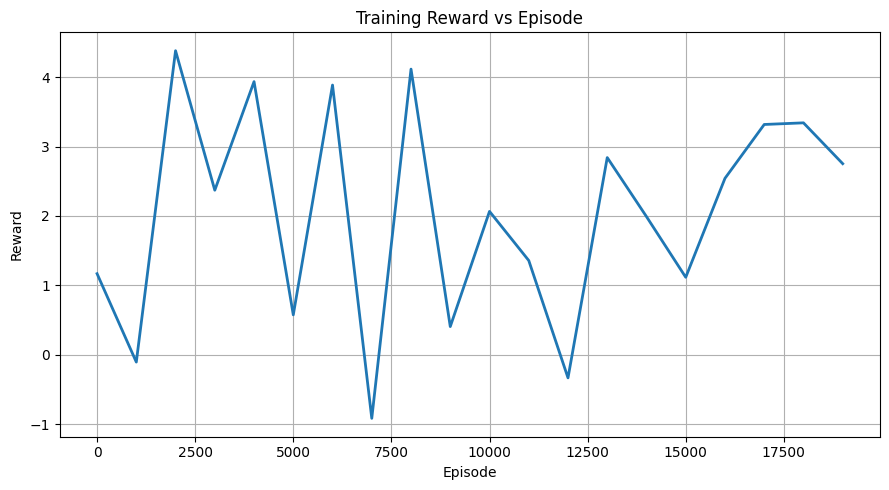

In [ ]:
import pandas as pd
#Training progress
log_dir = './nolimit_holdem_dqn_result/'
file_path = os.path.join(log_dir, 'performance.csv')

df = pd.read_csv("./nolimit_holdem_dqn_result/performance.csv")



plt.figure(figsize=(9, 5))
plt.plot(df["episode"], df["reward"], linewidth=2)

plt.title("Training Reward vs Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.tight_layout()
plt.show()

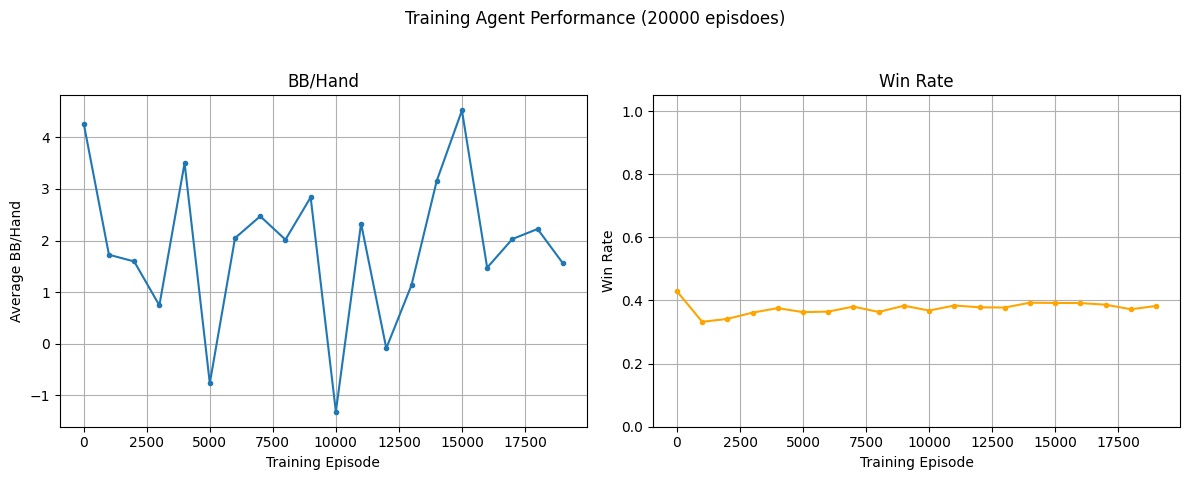

Training and evaluation complete.


In [ ]:
#evaluation Metrics
if episode_log:
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1) #BB/Hand
  #plt.figure(figsize=(10, 5))
  plt.plot(episode_log, bb_hand_log, marker='.')
  plt.xlabel("Training Episode")
  plt.ylabel("Average BB/Hand")
  plt.title("BB/Hand")
  plt.grid(True)

  plt.subplot(1, 2, 2) #win Rate
  #plt.figure(figsize=(10, 5))
  plt.plot(episode_log, win_rate_log, marker='.', color='orange')
  plt.xlabel("Training Episode")
  plt.ylabel("Win Rate")
  plt.title("Win Rate")
  plt.ylim(0, 1.05)
  plt.grid(True)


  plt.suptitle(f"Training Agent Performance ({num_episodes} episdoes)")
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

print("Training and evaluation complete.")

In [ ]:
import rlcard
import torch
import os
import matplotlib.pyplot as plt
from rlcard.agents import DQNAgent, RandomAgent


env_id = 'no-limit-holdem'
config = {
    'seed': 42,
    'game_num_players': 2,
}
env = rlcard.make(env_id, config=config)
set_seed(42)

def evaluate_dqn_vs_random(env, model_path, num_eval_games_test, eval_batch_size, device):
    loaded_dqn_agent = torch.load(model_path, map_location=device, weights_only=False )
    loaded_dqn_agent.set_device(device) # Ensure device is set after loading

    env.set_agents([loaded_dqn_agent] + [RandomAgent(num_actions=env.num_actions)])
    #env.set_agents([loaded_dqn_agent] + [dqn_agent])

    dqn_agent_index = 0
    random_agent_tracked_index = 1 # Track the first random agent (at index 1)

    eval_game_log = []
    #DQN Agent metrics
    bb_hand_log_dqn = []
    win_rate_log_dqn = []
    total_payoff_all_dqn = 0
    wins_all_dqn = 0
    #Random Agent metrics
    bb_hand_log_rand = []
    win_rate_log_rand = []
    total_payoff_all_rand = 0
    wins_all_rand = 0


    for game_batch_start in range(0, num_eval_games_test, eval_batch_size):
        batch_end = min(game_batch_start + eval_batch_size, num_eval_games_test)
        num_games_in_batch = batch_end - game_batch_start
        if num_games_in_batch <= 0: continue

        total_payoff_batch_dqn = 0
        wins_batch_dqn = 0
        total_payoff_batch_rand = 0
        wins_batch_rand = 0

        print(f"  Evaluating games {game_batch_start + 1} to {batch_end}")
        for game_num in range(num_games_in_batch):
          _, payoffs = env.run(is_training=False)

          # DQN Agent (Index 0)
          dqn_payoff_this_hand = payoffs[dqn_agent_index]
          total_payoff_batch_dqn += dqn_payoff_this_hand
          wins_batch_dqn += 1 if dqn_payoff_this_hand > 0 else 0

          # Random Agent (Index 1)
          rand_payoff_this_hand = payoffs[random_agent_tracked_index]
          total_payoff_batch_rand += rand_payoff_this_hand
          wins_batch_rand += 1 if rand_payoff_this_hand > 0 else 0



        #Calculate metrics
        # DQN
        avg_bb_hand_batch_dqn = total_payoff_batch_dqn / num_games_in_batch if num_games_in_batch > 0 else 0
        win_rate_batch_dqn = wins_batch_dqn / num_games_in_batch if num_games_in_batch > 0 else 0
        # Random
        avg_bb_hand_batch_rand = total_payoff_batch_rand / num_games_in_batch if num_games_in_batch > 0 else 0
        win_rate_batch_rand = wins_batch_rand / num_games_in_batch if num_games_in_batch > 0 else 0

        eval_game_log.append(batch_end) # Log
        # DQN
        bb_hand_log_dqn.append(avg_bb_hand_batch_dqn)
        win_rate_log_dqn.append(win_rate_batch_dqn)
        # Random
        bb_hand_log_rand.append(avg_bb_hand_batch_rand)
        win_rate_log_rand.append(win_rate_batch_rand)


        # DQN
        total_payoff_all_dqn += total_payoff_batch_dqn
        wins_all_dqn += wins_batch_dqn
        # Random
        total_payoff_all_rand += total_payoff_batch_rand
        wins_all_rand += wins_batch_rand


    # DQN
    final_avg_bb_hand_dqn = total_payoff_all_dqn / num_eval_games_test if num_eval_games_test > 0 else 0
    final_win_rate_dqn = wins_all_dqn / num_eval_games_test if num_eval_games_test > 0 else 0
    # Random
    final_avg_bb_hand_rand = total_payoff_all_rand / num_eval_games_test if num_eval_games_test > 0 else 0
    final_win_rate_rand = wins_all_rand / num_eval_games_test if num_eval_games_test > 0 else 0

    print("--- Final Evaluation Complete ---")
    print(f"Overall DQN (Agent {dqn_agent_index}) Avg BB/Hand vs Random: {final_avg_bb_hand_dqn:.4f}")
    print(f"Overall DQN (Agent {dqn_agent_index}) Win Rate vs Random: {final_win_rate_dqn:.4f}")
    print(f"Overall Tracked Random (Agent {random_agent_tracked_index}) Avg BB/Hand vs DQN+Random: {final_avg_bb_hand_rand:.4f}")
    print(f"Overall Tracked Random (Agent {random_agent_tracked_index}) Win Rate vs DQN+Random: {final_win_rate_rand:.4f}")

    return eval_game_log, bb_hand_log_dqn, win_rate_log_dqn, bb_hand_log_rand, win_rate_log_rand

  Evaluating games 1 to 500
  Evaluating games 501 to 1000
  Evaluating games 1001 to 1500
  Evaluating games 1501 to 2000
  Evaluating games 2001 to 2500
  Evaluating games 2501 to 3000
  Evaluating games 3001 to 3500
  Evaluating games 3501 to 4000
  Evaluating games 4001 to 4500
  Evaluating games 4501 to 5000
  Evaluating games 5001 to 5500
  Evaluating games 5501 to 6000
  Evaluating games 6001 to 6500
  Evaluating games 6501 to 7000
  Evaluating games 7001 to 7500
  Evaluating games 7501 to 8000
  Evaluating games 8001 to 8500
  Evaluating games 8501 to 9000
  Evaluating games 9001 to 9500
  Evaluating games 9501 to 10000
  Evaluating games 10001 to 10500
  Evaluating games 10501 to 11000
  Evaluating games 11001 to 11500
  Evaluating games 11501 to 12000
  Evaluating games 12001 to 12500
  Evaluating games 12501 to 13000
  Evaluating games 13001 to 13500
  Evaluating games 13501 to 14000
  Evaluating games 14001 to 14500
  Evaluating games 14501 to 15000
--- Final Evaluation Com

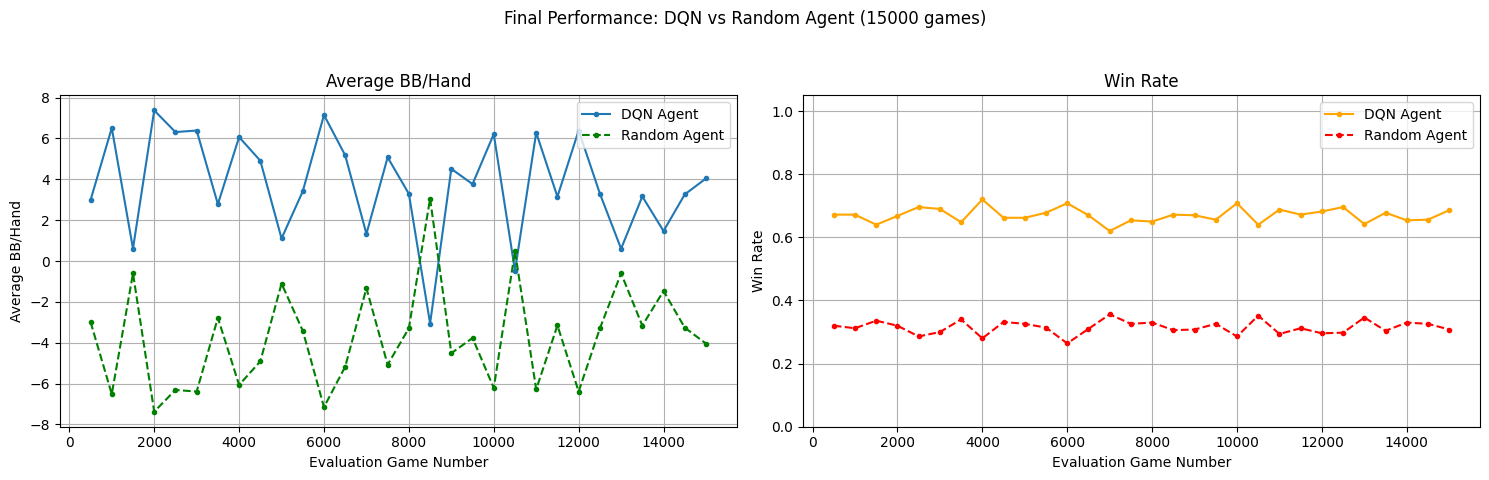

In [ ]:
num_eval_games_test = 15000
eval_batch_size = 500
eval_results = evaluate_dqn_vs_random(
    env=env,
    model_path=model_save_path,
    num_eval_games_test=num_eval_games_test,
    eval_batch_size=eval_batch_size,
    device=device
)


eval_game_log, bb_hand_log_dqn, win_rate_log_dqn, bb_hand_log_rand, win_rate_log_rand = eval_results





plt.figure(figsize=(15, 5))
#BB/Hand Subplot
plt.subplot(1, 2, 1)
#DQN Agent's BB/Hand
plt.plot(eval_game_log, bb_hand_log_dqn, marker='.', label='DQN Agent')
plt.plot(eval_game_log, bb_hand_log_rand, marker='.', linestyle='--', color='green', label='Random Agent')
plt.xlabel("Evaluation Game Number")
plt.ylabel("Average BB/Hand")
plt.title("Average BB/Hand")
plt.grid(True)
plt.legend()

#Win Rate Subplot
plt.subplot(1, 2, 2)
#DQN Agent's Win Rate
plt.plot(eval_game_log, win_rate_log_dqn, marker='.', color='orange', label='DQN Agent')
#Random Agent's Win Rate
plt.plot(eval_game_log, win_rate_log_rand, marker='.', linestyle='--', color='red', label='Random Agent')

plt.xlabel("Evaluation Game Number")
plt.ylabel("Win Rate")
plt.title("Win Rate")
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()


plt.suptitle(f"Final Performance: DQN vs Random Agent ({num_eval_games_test} games)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()